In [1]:
import numpy as np
import tqdm.notebook as tqdm

import src

import tensorflow.keras as keras
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
nb_points_per_patches = 1024
nb_patches=2048
nb_points = 100000


scenes_path = src.threeDMatch.get_sun3d_scenes(split="train")

def get_gen():
    while 1:
        gens = []
        for s in scenes_path[:1]:
            gens.append(src.threeDMatch.gen_scene_couple(s, "data/preprocessed-sun3d"))
        for examples in zip(*gens):
            for a,b in examples:
                yield a,b    

In [3]:
nb_points = 30000

def get_frame_cloud(frame):
    cloud = src.threeDMatch.get_cloud(frame, return_color=False)
    idx = np.random.choice(len(cloud), nb_points)
    return cloud[idx], src.threeDMatch.get_normals(cloud, idx=idx)

@tf.autograph.experimental.do_not_convert
def extract(path_a, path_b):
    cloud_a = get_frame_cloud(path_a.decode("utf-8"))
    cloud_b = get_frame_cloud(path_b.decode("utf-8"))
    extractor = src.dataset.PPFPatchExtractor(nb_patches=nb_patches, nb_points=nb_points_per_patches, tau=0.1)
    ppf, M = extractor.extract_pair(cloud_a, cloud_b)
    return ppf, M

def _map(path_a, path_b):
    y = tf.numpy_function(extract, [path_a, path_b], (tf.float32, tf.float32))
    return y

dataset = tf.data.Dataset.from_generator(get_gen, output_types=(tf.string, tf.string))
dataset = dataset.map(_map, num_parallel_calls=8)#Will do it in parrallel 
dataset = dataset.batch(4)
dataset = dataset.prefetch(4)

In [5]:
ppfnet = src.pointnet.PPFNet(input_shape = (2, None, None,10))
optimizer = keras.optimizers.Adam(lr=0.001)
ppfnet.model.compile(optimizer=optimizer, loss=src.loss.N_tuple_loss_pair(nb_patches))

In [7]:
#ppfnet.model.load_weights("models/sun_trained_9.tf")

In [8]:
loss = []
train_steps =  2000
pb = tqdm.tqdm(dataset.take(train_steps), total=train_steps)
for x,y in pb:
    res = ppfnet.model.train_on_batch(x,y)
    pb.set_description(f"loss {res:0.4}")
    pb.refresh() 
    loss.append(res)

In [10]:
ppfnet.model.save_weights("models/sun_trained_11.tf")

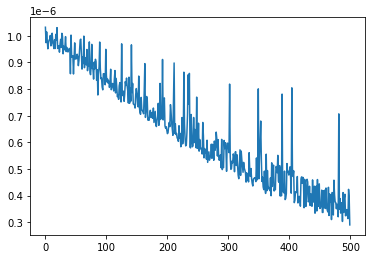

In [10]:
import matplotlib.pyplot as plt
plt.plot(loss)